In [39]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import datetime
from sklearn.metrics import roc_auc_score
import seaborn as sns
sns.set_style()
import pandas as pd
%matplotlib inline

In [40]:
datasplit_df = pd.read_csv('data/processed/train_test_valid_id_split.csv')[['videoid','dataset']]
datasplit_df['videoid'] = datasplit_df['videoid'].apply(lambda x: int(x))
alldata_processed =\
    pd.read_csv("./data/processed/alldata_processed.csv")
alldata_processed = alldata_processed.merge(right=datasplit_df,on=['videoid'],how='inner')

In [41]:
alldata_processed = pd.read_csv("./data/processed/alldata_processed.csv")

In [42]:
datasplit_df = pd.read_csv('data/processed/train_test_valid_id_split.csv')[['videoid','dataset']]
datasplit_df['videoid'] = datasplit_df['videoid'].apply(lambda x: int(x))
alldata_processed = alldata_processed.merge(right=datasplit_df,on=['videoid'],how='inner')
alldata_processed['const'] = 1

In [43]:
#age is truncated at 20 years because the relationship between age and SEMLS after 20 years is non-linear and 
#noisier
alldata_processed['age_truncated'] = np.clip(alldata_processed['age'],0,20)

In [44]:
#interpolate missing mass and height: there are only 6 instances where these values are missing
#interpolate missing mass
df_interp = alldata_processed[alldata_processed['dataset'] == 'train'].copy()
X = df_interp[["age_truncated","const"]].values
y = df_interp["mass"].values.reshape(-1,1)
lm = OLS(y,X,missing='drop').fit()

alldata_processed["predicted_mass"] = lm.predict(alldata_processed[["age_truncated","const"]].values)
alldata_processed["mass_interpolated"] = np.where(alldata_processed["mass"].isnull(),alldata_processed["predicted_mass"],
                                                 alldata_processed["mass"])

alldata_processed["log_interpolated_mass"] = np.log(alldata_processed["mass_interpolated"])
#interpolate missing height using log(mass)
df_interp = alldata_processed[alldata_processed['dataset'] == 'train'].copy()
X = df_interp[["log_interpolated_mass","const"]].values
y = df_interp["height"].values.reshape(-1,1)
lm = OLS(y,X,missing='drop').fit()

alldata_processed["predicted_height"] = lm.predict(alldata_processed[["log_interpolated_mass","const"]].values)

alldata_processed["height_interpolated"] = np.where(alldata_processed["height"].isnull(),alldata_processed["predicted_height"],
                                                 alldata_processed["height"])

In [45]:
#bucket data to make graphs
alldata_processed['mass_buckets'] =\
    np.clip(np.floor(alldata_processed['mass_interpolated']/5)*5,1,80)

alldata_processed['height_buckets'] =\
    np.clip(np.floor(alldata_processed['height_interpolated']/10)*10,90,180)
    
alldata_processed['age_buckets'] =\
    np.clip(np.floor(alldata_processed['age']),0,20)

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


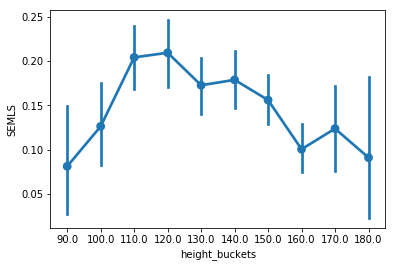

In [46]:
sns.pointplot(x='height_buckets',y='SEMLS',data=alldata_processed[alldata_processed['dataset'] == 'train'])

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


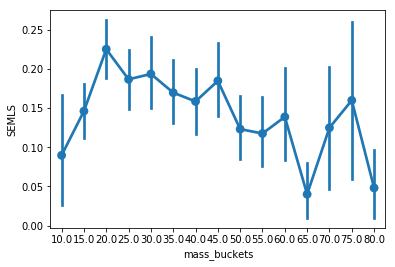

In [47]:
sns.pointplot(x='mass_buckets',y='SEMLS',data=alldata_processed[alldata_processed['dataset'] == 'train'])

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


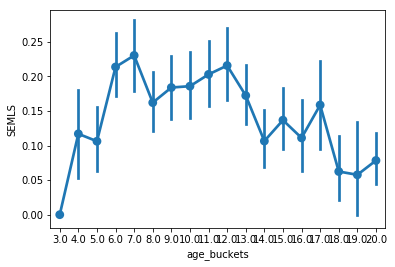

In [48]:
sns.pointplot(x='age_buckets',y='SEMLS',data=alldata_processed[alldata_processed['dataset'] == 'train'])

In [49]:
alldata_processed['mass_interpolated2'] = np.square(alldata_processed['mass_interpolated'])/100
alldata_processed['age_truncated2'] = np.square(alldata_processed['age_truncated'])/100
alldata_processed['height_interpolated2'] = np.square(alldata_processed['height_interpolated'])/100

In [50]:
from statsmodels.regression.linear_model import OLS
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
print(list(alldata_processed))
print(alldata_processed.describe())
Xcols = ["mass_interpolated","mass_interpolated2","age_truncated2","age_truncated",
         "height_interpolated","height_interpolated2",
         #"isPostSurgGaitVisit",
         "const"]

X_train = alldata_processed[alldata_processed['dataset'] == 'train'][Xcols]
y_train = alldata_processed[alldata_processed['dataset'] == 'train']["SEMLS"]
X = alldata_processed[Xcols].values
y = alldata_processed["SEMLS"].values

lm = Logit(y_train,X_train).fit()


alldata_processed['predicted_SEMLS'] = lm.predict(X)

['Patient_ID', 'examid', 'side', 'HipFlex_IC', 'HipRot_mean', 'KneeFlex_meanStance', 'KneeFlex_maxExtension', 'dxmod', 'dxside', 'faq', 'gmfcs', 'age', 'height', 'mass', 'cadence', 'speed', 'steplen', 'leglen', 'bmi', 'speedNorm', 'steplenNorm', 'cadenceNorm', 'videoid', 'GDI', 'n_sides', 'SEMLS', 'dataset', 'const', 'age_truncated', 'predicted_mass', 'mass_interpolated', 'log_interpolated_mass', 'predicted_height', 'height_interpolated', 'mass_buckets', 'height_buckets', 'age_buckets', 'mass_interpolated2', 'age_truncated2', 'height_interpolated2']
         Patient_ID        examid   HipFlex_IC  HipRot_mean  \
count   4424.000000   4424.000000  4424.000000  4424.000000   
mean    6408.935805   9468.898282    44.914568     2.344195   
std     1409.316041   2509.549493     9.081778    11.765351   
min     3466.000000    933.000000    14.812710   -37.810049   
25%     5216.250000   7487.000000    38.951835    -5.302441   
50%     6513.500000   9341.000000    44.672674     2.009960   
75%

In [51]:
lm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:               Logit             Pseudo R-squared:  0.016     
Dependent Variable:  SEMLS             AIC:               3085.4294 
Date:                2020-05-21 21:31  BIC:               3128.6247 
No. Observations:    3536              Log-Likelihood:    -1535.7   
Df Model:            6                 LL-Null:           -1560.0   
Df Residuals:        3529              LLR p-value:       8.8042e-09
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      7.0000                                         
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
mass_interpolated    -0.0029   0.0192 -0.1505 0.8803 -0.0404  0.0347
mass_interpolated2   -0.0055   0.0174 -0.3145 0.7531 -0.0396  0.0286
age_truncated2       -1.3221   0.3927 -3.3664 0.0008 -2.0918 -0.5523
age_truncated         0.3173   0.1094  2.9005 0.0037  0.1029  0.5318
height_interpolated   0.0127   0.0411  0.3092 0.7572 -0.0679  0.0933
height_interpolated2 -0.0064   0.0141 -0.4502 0.6526 -0.0340  0.0213
const                -3.6450   2.4999 -1.4581 0.1448 -8.5447  1.2547
====================================================================

"""

In [52]:
def compute_deviance_residual(y,predicted_prob):
    return np.where(y==1,np.sqrt(-2.0*np.log(predicted_prob)),
                                 -np.sqrt(-2.0*np.log(1-predicted_prob)))

In [53]:
roc_auc_score(alldata_processed[alldata_processed['dataset'] == 'train']['SEMLS'],
              alldata_processed[alldata_processed['dataset'] == 'train']['predicted_SEMLS'])

0.583489562694028

In [54]:
roc_auc_score(alldata_processed[alldata_processed['dataset'] == 'validation']['SEMLS'],
              alldata_processed[alldata_processed['dataset'] == 'validation']['predicted_SEMLS'])

0.6027171675586661

In [55]:
alldata_processed['SEMLS_dev_residual'] = compute_deviance_residual(y,
                                                                   lm.predict(X))

In [56]:
alldata_processed.to_csv("./data/processed/alldata_processed_with_dev_residual.csv",index=False)

In [57]:
alldata_processed['SEMLS_dev_residual'].std()

0.918462466958801